C:\Users\Esmit\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-1-1497509c2ae5>:56: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = movie_data.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
<ipython-input-1-1497509c2ae5>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_md['tagline'] = small_md['tagline'].fillna('')
<ipython-input-1-1497509c2ae5>:104: SettingWithCopyWarning: 
A value

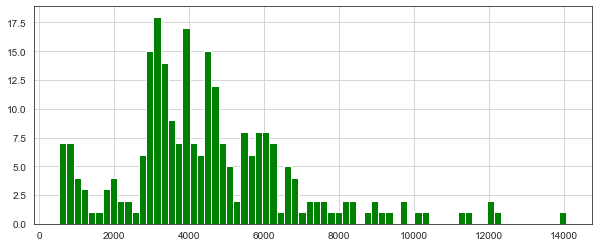

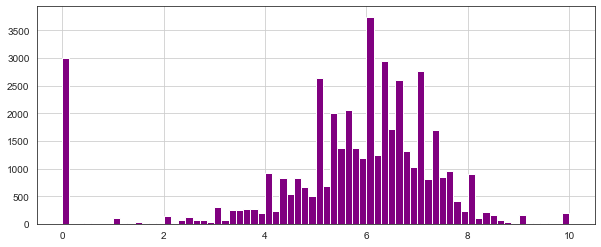

In [1]:
# imports

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# loading movie_metadata file and categorizing by genre
movie_data = pd.read_csv('sample_data/movies_metadata.csv')
movie_data.head()

# listing movies based on genre
movie_data['genres'] = movie_data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

'''
top movies chart (95% and above rating) by calculating the weighted rating
v is the number of votes for the movie
min_votes is the minimum votes required to be listed in the chart
avg_rating is the average rating of the movie
c is the mean vote across the whole report
'''

total_votes = movie_data[movie_data['vote_count'].notnull()]['vote_count'].astype('int')
avg_vote = movie_data[movie_data['vote_average'].notnull()]['vote_average'].astype('int')
c = avg_vote.mean()
c
min_votes = total_votes.quantile(0.95)
min_votes

# categorizing based on release date and year
movie_data['year'] = pd.to_datetime(movie_data['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

# for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.
feature = movie_data[(movie_data['vote_count'] >= min_votes) & (movie_data['vote_count'].notnull()) & (movie_data['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
feature['vote_count'] = feature['vote_count'].astype('int')
feature['vote_average'] = feature['vote_average'].astype('int')
feature.shape

# calculate the weighted rating to feature the movie in the chart
def weighted_rating(x):
    v = x['vote_count']
    avg_rating = x['vote_average']
    return (v/(v+min_votes) * avg_rating) + (min_votes/(min_votes+v) * c)
    
# to list top rated movies (250)   
feature['weighted_rate'] = feature.apply(weighted_rating, axis=1)
feature = feature.sort_values('weighted_rate', ascending=False).head(250)
feature.head(15)

# function to build charts for specific genres
s = movie_data.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_movie_data = movie_data.drop('genres', axis=1).join(s)

# lists the top 15 movies in a spefic genre
def build_chart(genre, percentile=0.85):
    df = gen_movie_data[gen_movie_data['genre'] == genre]
    total_votes= df[df['vote_count'].notnull()]['vote_count'].astype('int')
    avg_vote = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    c = avg_vote.mean()
    min_votes = total_votes.quantile(percentile)
    
    feature = df[(df['vote_count'] >= min_votes) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    feature['vote_count'] = feature['vote_count'].astype('int')
    feature['vote_average'] = feature['vote_average'].astype('int')
    
    feature['weighted_rate'] = feature.apply(lambda x: (x['vote_count']/(x['vote_count']+min_votes) * x['vote_average']) + (min_votes/(min_votes+x['vote_count']) * c), axis=1)
    feature = feature.sort_values('weighted_rate', ascending=False).head(250)
    
    return feature
    
# list movies from genre 'Romance' (other genres - Action, Adventure, Comedy, Thriller)
build_chart('Thriller').head(15)

 # displaying bar graph for average vote counts for a specific genre   
sns.set_style('white')
plt.figure(figsize=(10,4))
feature['vote_count'].hist(bins=70,color='green')
    
'''
content based recommendation
1. Movie Overviews and Taglines
2. Movie Cast, Crew, Keywords and Genre
'''
links_small = pd.read_csv('sample_data/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

# accessing small movies dataset with 9000+ data
movie_data = movie_data.drop([19730, 29503, 35587])
movie_data['id'] = movie_data['id'].astype('int')
small_md = movie_data[movie_data['id'].isin(links_small)]
small_md.shape

'''
Using the TF-IDF Vectorizer, we calculate the Dot Product and it
will give us the Cosine Similarity Score.
'''
small_md['tagline'] = small_md['tagline'].fillna('')
small_md['description'] = small_md['overview'] + small_md['tagline']
small_md['description'] = small_md['description'].fillna('')
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(small_md['description'])
tfidf_matrix.shape

'''
using cosine similarity, we will be able to calculate a numeric quantity that 
denotes the similarity between two movies.
'''
# finding the similarity between movies using cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

'''
listing the movies based on the cosine similarity scores
lets us list movies similar to the given titles
'''
small_md = small_md.reset_index()
titles = small_md['title']
indices = pd.Series(small_md.index, index=small_md['title'])

def get_recommendations(title):
    idx = indices[title]
    similarity_scores = list(enumerate(cosine_sim[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:31]
    movie_indices = [i[0] for i in similarity_scores]
    return titles.iloc[movie_indices]

# recommends the movies based on the title (other titles - Inception, The Dark Knight, Frozen, Star Wars)
get_recommendations('Forrest Gump').head(10)

get_recommendations('Se7en').head(10)

# displaying bar graph for average vote counts for similar titles
plt.figure(figsize=(10,4))
movie_data['vote_average'].hist(bins=70,color='purple')

In [4]:
'''
Interest based filtering
Function to filter movies based on interests entered by the user
This function calculates how similar the movies are to the user input by using the ROCK similarity calculation
'''

def interestFilter(interests):
    #load keyword dataset
    movie_interests = pd.read_csv('sample_data/keywords.csv')
    #similarity and difference counts used for similarity calculations
    simCount = 0
    diffCount = 0
    #used to determine if a keyword is excluded in a tuple
    excluded = True
    #stores the movie id and similarity measument for each tuple
    similarities = {}
    #iteration variable
    i = 0
    #used to measure tuple load error rate
    errorrate = 0
    
    #loop through each tuple in the dataset
    while i < movie_interests.shape[0]:
        #reset counts
        diffCount = 0
        simCount = 0
        
        #try to load tuple, and turn it into an array of dictionaries
        try:
            movieTuple = [movie_interests.iloc[i][1]]
            res = [json.loads(idx.replace("'", '"')) for idx in movieTuple]   
        #if tuple fails to properly load or convert, add to errorrate and proceed to next tuple
        except:
            errorrate+=1
         
        #iteration variable
        j = 0
        
        #iterate through each user input interest
        while j < len(interests):
            #reset excluded variable
            excluded = True
            #iteration variable
            k = 0
            
            #loop through each keyword in tuple, comparing them to user input variable
            while k<len(res[0]):
                #if user input variable equals keyword in movie, add to similar count and indicate the keyword is not excluded
                if interests[j].lower() == res[0][k]['name'].lower():
                    excluded = False
                    simCount += 1
                k+=1     
            
            #if the keyword was excluded in the tuple, add to difference count
            if(excluded):
                diffCount+=1

            j+=1
        
        #calculates the similarity between user input and the current tuple
        simCount=simCount/(k+diffCount)
        #updates the similarity dictionary with the movie id and the similarity rating
        similarities.update({movie_interests.id[i]:simCount}) 
        i+=1
    #turns the similarity dictionary into a list to be reverse sorted to allow the highest similarities at the beginning
    similarities =  list(sorted(similarities.items(), key=lambda item: item[1], reverse=True))
    i = 0
    titles = []
    while i < 10:
        titles.append(movie_data.loc[movie_data.id == similarities[i][0]].title)   
        i+=1
    return titles

'''
Collaberation based filtering
Collaberation based filtering works by calulating how similar users are to one another by using likes, dislikes and user actions
to calculate similarity
This block of code will calculate how similar each user is to one another using user rating data
'''
#import user ratings
user_ratings = pd.read_csv('sample_data/ratings_small.csv')
user_ratings.drop(['timestamp'], axis=1, inplace=True)
#user id used to identify different user ratings
userId=1
#stores a users highest rated movie
fave_movie = ''
#contains a list of a users favorite movies
user_movies = []
#user id start at 1 and so does this array for simplicity
user_movies.append('')
#contains user ratings used in calculations
highest_rating = 0
current_rating = 0
#contains a list of a users fave movies
fav_movies = []
#error rate to catch errors
errorrate = 0
#iteration variable
i=0
#loop through each tuple to set each users 10 favorite movies
#these will be used later to calculate how similar each user is to one another
while i < user_ratings.shape[0]:
    #try to load each tuple, if any problems occur skip tuple
    try:
        #if there is a different user, set variables to account for the difference
        if(user_ratings.iloc[i]['userId']!=userId):
            #append the users list of favorite movies to the user_movies list
            user_movies.append(fav_movies.copy())
            #clear the current users favorite movie list
            fav_movies.clear()
            #resets highest rating
            highest_rating = 0
            #increments to next user
            userId+=1
            #deincrements i to the previous tuple so that the calculations will include the current tuple
            i-=1
            
        else:
            #gets the users rating of the current movie
            current_rating = user_ratings.iloc[i]['rating']
            #sets the first 10 ratings as the users default favorite movies
            if(len(fav_movies)<10):
                #if the movie id matches a title id in the movie metadata dataset, append this to the movie list
                #this is to ensure there are no empty movie titles
                if movie_data.loc[movie_data.id == user_ratings.iloc[i]['movieId']].title.values.size > 0:
                    fav_movies.append([user_ratings.iloc[i]['movieId'], current_rating])
            
            else:  
                #if the movie id matches a title id in the movie metadata dataset, append this to the movie list
                #this is to ensure there are no empty movie titles
                if movie_data.loc[movie_data.id == user_ratings.iloc[i]['movieId']].title.values.size > 0:
                    #set iteration variable
                    j=0
                    #loop through each favorite movie to check if the current movie has a higher rating than one currently
                    #on the list
                    while j < 10:
                        #if the current movie rating is higher than the movie on the list, replace with the new tuple
                        if(fav_movies[j][1]<current_rating ):
                            #Sets new favorite movie and rating
                            fav_movie = user_ratings.iloc[i]['movieId']
                            highest_rating = current_rating
                            #if a tuple has been replaced, use temporary variables
                            if replace:
                                #sets the replacement variables
                                replacement_id = temp_id
                                replacement_rating = current_rating
                                #sets temp data for future iterations
                                temp_id = fav_movies[j][0]
                                current_rating = fav_movies[j][1]
                                #sets new values for favorite movie array
                                fav_movies[j][0] = replacement_id
                                fav_movies[j][1] = replacement_rating
                            #if a tuple has not been replaced, replace lower rated movie with current movie
                            else:
                                #sets temp data for future use
                                temp_id = fav_movies[j][0]
                                current_rating = fav_movies[j][1]
                                #sets new values for favorite movie array
                                fav_movies[j][0] = fav_movie
                                fav_movies[j][1] = highest_rating
                                #set replace to true to allow for additional tuple checks
                                replace = True
                        j+=1
                    #resets replace variable
                    replace=False  
    #catches any error that occurs when accessing dataset
    except:
        errorrate+=1
    i+=1

#similarity holds the similarity calculations between users
smilarity = 0
#best will hold the highest similarity result for the users
best = 0
#holds the id of the user with the most similar movie preferences
closest_user = 0
#holds the best user pairs
best_matches = []
#start array at 1
best_matches.append(0)
#resetting iteration variable
i=1
while i<len(user_movies):
    #resetting iteration variable
    k=1
    #resets best variable
    best = 0
    #loop through each users and their favorite movies
    while k < len(user_movies):
        #finds the intersection of the current users favorite moviess and a different users favorite movies
        #sets similarity to this calculation
        simimlarity = np.intersect1d(user_movies[i],user_movies[k])
        #try to calulate similarity using ROCK similarity methods 
        try:
            #set similarity to number of similar elements divided by number of total elements in each favorite movie list
            simimlarity = float(len(simimlarity)/(len(user_movies[k]) + len(user_movies[i]) - len(simimlarity)))
        #catches calculations such as division by 0    
        except:
            #sets similarity to 0 if an error occurs
            simimlarity = 0
        
        #if the current similarity is better than the previous best and also not the same user id
        if simimlarity>best and i!=k : 
            #set best as the new value
            best = simimlarity
            #sets the closest user to the current tuple id
            closest_user=k
        k+=1   
    #adds the best match to the array
    best_matches.append(closest_user)
    i+=1
#This method will print the list of recommended movies for the user
#the user id is input as a variable and used to find which user matches their interests
def collabFilter(userId):
    #iteration variable
    i = 0
    #print line describing user input
    titles = []
    #goes through each item on the other users favorite movie list
    while i < len(user_movies[best_matches[userId]]):
        #prints each movie title the best match user likes
        titles.append(movie_data.loc[movie_data.id == user_movies[best_matches[userId]][i][0]].title.values)
        i+=1
    #prints other user that list was pulled from
    return titles

#calls interest filter to get list of recommended movie based on interests
interests = ['batman', 'fighting', 'robin', 'super powers']
titles = interestFilter(interests)
print("Interests: ", interests)
for title in titles:
    print(title.values)
print()
#calls collab filter on user 324 and user 7
print('User #324 would like:')
titles = collabFilter(324)
for title in titles:
    print(title)
print()
print('User #7 would like:')
titles = collabFilter(7)
for title in titles:
    print(title)


Interests:  ['batman', 'fighting', 'robin', 'super powers']
['Batman & Mr. Freeze: SubZero']
['Batman vs. Robin']
['Batman: Bad Blood']
['Return to the Batcave: The Misadventures of Adam and Burt']
['Lego Batman: The Movie - DC Super Heroes Unite']
['Batman: Mystery of the Batwoman']
['Son of Batman']
['Batman Unlimited: Animal Instincts']
['Batman & Bill']
['Batman: The Dark Knight Returns, Part 2']
User # 671  would like:
['The Million Dollar Hotel']
['The Sixth Sense']
['Three Colors: Red']
['Greed']
['Donnie Darko']
['Monsoon Wedding']
['Terminator Salvation']
['The 39 Steps']
['The Man with the Golden Arm']
['The Poseidon Adventure']

User # 671  would like:
['The Powerpuff Girls Movie']
['The Million Dollar Hotel']
['Reservoir Dogs']
['American History X']
['Three Colors: Red']
['The Poseidon Adventure']
['Donnie Darko']
['48 Hrs.']
['Silent Hill']
['The Conversation']

